In [1]:
from plotting_functions import *
import matplotlib as mpl
import glob
import os
import pandas as pd
import warnings
import tempfile
import shutil
from matplotlib.font_manager import FontProperties

---

### Variance Difference Datasets:

In [2]:
index = 705
variables = ['pr','pr_5d','snc','dtr','vpd','sfcwind','GPP_50d','GPP_1yr']

mask_h = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                         'wildfires_theo_keeping/live/ensemble_data/'+
                         'mask_conus_2000_2009.nc').mask.to_numpy()

mask_s = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                         'wildfires_theo_keeping/live/ensemble_data/'+
                         'mask_conus_2075_2084.nc').mask.to_numpy()

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ds1 = xr.open_mfdataset(f'/rds/general/user/tk22/ephemeral/loo/p_loo_none_historical*.nc') # Run NB1 first
    da1 = ds1.p.var(dim = ['time','member'])

    loo_maps_h_all = da1.to_dataset().rename({'p': 'original'})
    loo_maps_h_top = da1.to_dataset().rename({'p': 'original'})

    quant_thresh = np.nanquantile(ds1.p.to_numpy(), 0.99, axis = (0,1))
    indices = (ds1.p.to_numpy() >= quant_thresh)

    for var in variables:
        print(var)
        ds2 = xr.open_mfdataset(f'/rds/general/user/tk22/ephemeral/loo/p_loo_{var}_historical*.nc')
        temp = np.abs(ds1.p.sortby('member').to_numpy() - 
                      ds2.p.sortby('member').to_numpy())

        temp_all = np.nanmean(temp, axis = (0,1))
        temp_cent = np.zeros((indices.shape[2], indices.shape[3])) * np.nan

        for i in range(indices.shape[2]):
            for j in range(indices.shape[3]):
                temp_cent[i,j] = np.nanmean(temp[:,:,i,j][indices[:,:,i,j]])

        loo_maps_h_all[var] = (['latitude','longitude'], temp_all)
        loo_maps_h_top[var] = (['latitude','longitude'], temp_cent)

pr
pr_5d
snc
dtr
vpd
sfcwind
GPP_50d
GPP_1yr


In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    ds1 = xr.open_mfdataset(f'/rds/general/user/tk22/ephemeral/loo/p_loo_none_projected*.nc') # Run NB1 first
    da1 = ds1.p.var(dim = ['time','member'])

    loo_maps_s_all = da1.to_dataset().rename({'p': 'original'})
    loo_maps_s_top = da1.to_dataset().rename({'p': 'original'})

    quant_thresh = np.nanquantile(ds1.p.to_numpy(), 0.99, axis = (0,1))
    indices = (ds1.p.to_numpy() >= quant_thresh)

    for var in variables:
        print(var)
        ds2 = xr.open_mfdataset(f'/rds/general/user/tk22/ephemeral/loo/p_loo_{var}_projected*.nc')
        temp = np.abs(ds1.p.sortby('member').to_numpy() - 
                      ds2.p.sortby('member').to_numpy())

        temp_all = np.nanmean(temp, axis = (0,1))
        temp_cent = np.zeros((indices.shape[2], indices.shape[3])) * np.nan

        for i in range(indices.shape[2]):
            for j in range(indices.shape[3]):
                temp_cent[i,j] = np.nanmean(temp[:,:,i,j][indices[:,:,i,j]])

        loo_maps_s_all[var] = (['latitude','longitude'], temp_all)
        loo_maps_s_top[var] = (['latitude','longitude'], temp_cent)

pr
pr_5d
snc
dtr
vpd
sfcwind
GPP_50d
GPP_1yr


In [5]:
code_dict_h_all = dict()
code_dict_s_all = dict()
code_dict_h_top = dict()
code_dict_s_top = dict()

for i,var in enumerate(variables):
    print(var)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        test_data_h_all = loo_maps_h_all[var].to_numpy()
        test_data_s_all = loo_maps_s_all[var].to_numpy()
        test_data_h_top = loo_maps_h_top[var].to_numpy()
        test_data_s_top = loo_maps_s_top[var].to_numpy()
        if i == 0:
            codes_h_all = np.zeros(test_data_h_all.shape)
            codes_s_all = np.zeros(test_data_s_all.shape)
            codes_h_top = np.zeros(test_data_h_top.shape)
            codes_s_top = np.zeros(test_data_s_top.shape)
            prev_max_h_all = test_data_h_all
            prev_max_s_all = test_data_s_all
            prev_max_h_top = test_data_h_top
            prev_max_s_top = test_data_s_top
        else:
            where = (test_data_h_all > prev_max_h_all)
            codes_h_all[where] = i
            prev_max_h_all[where] = test_data_h_all[where]
            
            where = (test_data_s_all > prev_max_s_all)
            codes_s_all[where] = i
            prev_max_s_all[where] = test_data_s_all[where]
            
            where = (test_data_h_top > prev_max_h_top)
            codes_h_top[where] = i
            prev_max_h_top[where] = test_data_h_top[where]
            
            where = (test_data_s_top > prev_max_s_top)
            codes_s_top[where] = i
            prev_max_s_top[where] = test_data_s_top[where]
        
        code_dict_h_all[var] = i
        code_dict_s_all[var] = i
        code_dict_h_top[var] = i
        code_dict_s_top[var] = i

pr
pr_5d
snc
dtr
vpd
sfcwind
GPP_50d
GPP_1yr


### Bar Chart Data:

In [6]:
cell_area = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                            'wildfires_theo_keeping/live/ensemble_data/'+
                            'cell_area_6min_19920101_20201231.nc'+
                            '')['cell_area'][0,:,:].to_numpy()

df = pd.DataFrame(index = np.arange(len(code_dict_h_all.keys())))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    df['h_all'] = 0
    for i in range(8):
        df['h_all'].loc[i] = np.nansum((codes_h_all*mask_h == i)*mask_h*cell_area)

    df['s_all'] = 0
    for i in range(8):
        df['s_all'].loc[i] = np.nansum((codes_s_all*mask_s == i)*mask_s*cell_area)

    df['h_top'] = 0
    for i in range(8):
        df['h_top'].loc[i] = np.nansum((codes_h_top*mask_h == i)*mask_h*cell_area)

    df['s_top'] = 0
    for i in range(8):
        df['s_top'].loc[i] = np.nansum((codes_s_top*mask_s == i)*mask_s*cell_area)

df['index'] = list(code_dict_h_all.keys())
df = df.set_index('index')

In [7]:
print(df['s_all']['GPP_1yr'])
print(df['h_all']['GPP_1yr'])

print(df['s_all']['GPP_1yr'] / df['s_all'].sum())
print(df['h_all']['GPP_1yr'] / df['s_all'].sum())

5286275.184723476
4485013.754093932
0.7105778249672557
0.6028727614374092


In [8]:
df

,h_all,s_all,h_top,s_top
index,,,,
pr,3.930195e+04,1.992660e+02,3.835634e+04,9.892859e+01
pr_5d,0.000000e+00,0.000000e+00,3.301209e+02,0.000000e+00
snc,0.000000e+00,0.000000e+00,0.000000e+00,1.841906e+02
dtr,2.842592e+05,5.587463e+05,5.270167e+04,1.146773e+04
vpd,2.504498e+06,8.497626e+05,5.687927e+06,4.756253e+06
sfcwind,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
GPP_50d,2.301231e+05,7.444202e+05,1.411041e+05,9.594795e+05
GPP_1yr,4.485014e+06,5.286275e+06,1.622777e+06,1.711920e+06


### Bar Chart:

/var/tmp/pbs.126725.pbs/ipykernel_2201609/204309547.py:83: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax5.get_shared_x_axes().remove(ax5)
/var/tmp/pbs.126725.pbs/ipykernel_2201609/204309547.py:84: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax5.get_shared_y_axes().remove(ax5)


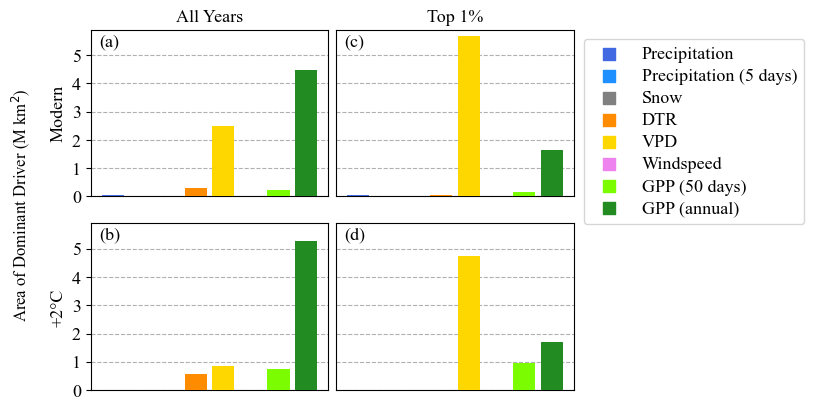

In [16]:
tnr = FontProperties(fname = '/rds/general/user/tk22/home/fonts/times.ttf',
                     size = 13)

colours = ['royalblue','dodgerblue','grey','darkorange',
           'gold','violet','lawngreen','forestgreen']
labels = ['Precipitation','Precipitation (5 days)', 
          'Snow', 'DTR', 'VPD', 'Windspeed',
          'GPP (50 days)', 'GPP (annual)']

fig = plt.figure(layout = "constrained", figsize = (8,4))
gs = mpl.gridspec.GridSpec(2, 5, figure = fig)

ax1 = fig.add_subplot(gs[0,:2])
ax1.grid(axis = 'y', which = 'major', linestyle = '--')
ax1.bar(df.index, df['h_all'], color = colours, zorder = 100)
ax1.set_xticks([])
ax1.set_yticks([0,1e6,2e6,3e6,4e6,5e6],[0,1,2,3,4,5], font = tnr)
ax1.set_ylim((0,6e6-1e5))
ax1.set_ylabel('Modern', fontsize = 13, font = tnr)
ax1.set_title('All Years', fontsize = 13, font = tnr)
ax1.text(-0.5, 5.2e6, f'(a)', color = 'k',
         font = tnr,
         fontsize = 13, ha = 'left', va = 'bottom',
         bbox = dict(facecolor = 'white',
                     edgecolor = 'white',
                     pad = 0))


ax2 = fig.add_subplot(gs[1,:2])
ax2.grid(axis = 'y', which = 'major', linestyle = '--')
ax2.bar(df.index, df['s_all'], color = colours, zorder = 101)
ax2.set_xticks([])
ax2.set_yticks([0,1e6,2e6,3e6,4e6,5e6],[0,1,2,3,4,5], font = tnr)
ax2.set_ylim((0,6e6-1e5))
ax2.set_ylabel('+2°C', fontsize = 13, font = tnr)
fig.supylabel('Area of Dominant Driver (M km$^{2}$)', font = tnr,
              va = 'center', ha = 'center')
ax2.text(-0.5, 5.2e6, f'(b)', color = 'k', font = tnr,
         fontsize = 13, ha = 'left', va = 'bottom',
         bbox = dict(facecolor = 'white',
                     edgecolor = 'white',
                     pad = 0))

ax3 = fig.add_subplot(gs[0,2:4])
ax3.grid(axis = 'y', which = 'major', linestyle = '--')
ax3.bar(df.index, df['h_top'], color = colours, zorder = 100)
ax3.set_xticks([])
ax3.set_yticks([0,1e6,2e6,3e6,4e6,5e6],[0,1,2,3,4,5], font = tnr)
ax3.set_yticklabels([])
ax3.tick_params(length = 0)
ax3.set_ylim((0,6e6-1e5))
ax3.set_title('Top 1%', fontsize = 13, font = tnr)
ax3.text(-0.5, 5.2e6, f'(c)', color = 'k', font = tnr,
         fontsize = 13, ha = 'left', va = 'bottom',
         bbox = dict(facecolor = 'white',
                     edgecolor = 'white',
                     pad = 0))

ax4 = fig.add_subplot(gs[1,2:4])
ax4.grid(axis = 'y', which = 'major', linestyle = '--')
ax4.bar(df.index, df['s_top'], color = colours, zorder = 101)
ax4.set_xticks([])
ax4.set_yticks([0,1e6,2e6,3e6,4e6,5e6],[0,1,2,3,4,5], font = tnr)
ax4.set_yticklabels([])
ax4.tick_params(length = 0)
ax4.set_ylim((0,6e6-1e5))
ax4.text(-0.5, 5.2e6, f'(d)', color = 'k',
         font = tnr,
         fontsize = 13, ha = 'left', va = 'bottom',
         bbox = dict(facecolor = 'white',
                     edgecolor = 'white',
                     pad = 0))



ax5 = fig.add_subplot(gs[:2,4])
for i,c in enumerate(colours):
    ax5.scatter([1e5],[1e5],marker = 's',color = c, label = labels[i])
ax5.set_xlim((0,1))
ax5.set_ylim((0,1))
ax5.legend(fontsize = 13, labelspacing = 0.3, markerscale = 1.4, prop = tnr)

ax5.get_shared_x_axes().remove(ax5)
ax5.get_shared_y_axes().remove(ax5)
ax5.grid(False)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.xaxis.set_visible(False)
ax5.yaxis.set_visible(False)


plt.savefig(('/rds/general/user/tk22/home/paper_2/'+
             f'final_figures/figures/figure_2.jpg'), 
            bbox_inches = 'tight', facecolor = 'white', dpi = 300)
plt.show()

### Maps:

/var/tmp/pbs.126725.pbs/ipykernel_2201609/101962446.py:83: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax5.get_shared_x_axes().remove(ax5)
/var/tmp/pbs.126725.pbs/ipykernel_2201609/101962446.py:84: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax5.get_shared_y_axes().remove(ax5)
/var/tmp/pbs.126725.pbs/ipykernel_2201609/101962446.py:94: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0)


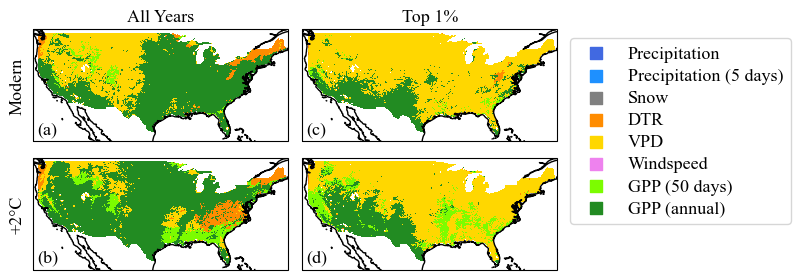

In [18]:
tnr = FontProperties(fname = '/rds/general/user/tk22/home/fonts/times.ttf',
                     size = 13)

colours = ['royalblue','dodgerblue','grey','darkorange',
           'gold','violet','lawngreen','forestgreen']
labels = ['Precipitation','Precipitation (5 days)', 
          'Snow', 'DTR', 'VPD', 'Windspeed',
          'GPP (50 days)', 'GPP (annual)']
col_dict = {0: "royalblue",
            1: "dodgerblue",
            2: "grey",
            3: "darkorange",
            4: "gold",
            5: "violet",
            6: "lawngreen",
            7: "forestgreen"}
cm = mpl.colors.ListedColormap([col_dict[x] for x in col_dict.keys()])

fig = plt.figure(layout = "constrained", figsize = (8,2.7))
gs = mpl.gridspec.GridSpec(2, 5, figure = fig)

ax1 = fig.add_subplot(gs[0,:2], projection = ccrs.PlateCarree())
ax1.set_global()
ax1.coastlines()
ax1.set_xlim(-125, -67)
ax1.set_ylim(24, 49.5)
im = ax1.pcolormesh(da1.longitude, da1.latitude, codes_h_all*mask_s, cmap = cm)
ax1.annotate('Modern', (-0.09, 0.50), xycoords = 'axes fraction',
             rotation = 90, va = 'center', fontsize = 13, font = tnr)
ax1.set_title('All Years', fontsize = 13, font = tnr)
ax1.text(-124, 25, f'(a)', color = 'k', font = tnr,
         fontsize = 13, ha = 'left', va = 'bottom',
         bbox = dict(facecolor = 'white',
                     edgecolor = 'white',
                     pad = 0))

ax2 = fig.add_subplot(gs[1,:2], projection = ccrs.PlateCarree())
ax2.set_global()
ax2.coastlines()
ax2.set_xlim(-125, -67)
ax2.set_ylim(24, 49.5)
im = ax2.pcolormesh(da1.longitude, da1.latitude, codes_s_all*mask_s, cmap = cm)
ax2.annotate('+2°C', (-0.09, 0.50), xycoords = 'axes fraction',
             rotation = 90, va = 'center', fontsize = 13, font = tnr)
ax2.text(-124, 25, f'(b)', color = 'k', font = tnr,
         fontsize = 13, ha = 'left', va = 'bottom',
         bbox = dict(facecolor = 'white',
                     edgecolor = 'white',
                     pad = 0))

ax3 = fig.add_subplot(gs[0,2:4], projection = ccrs.PlateCarree())
ax3.set_global()
ax3.coastlines()
ax3.set_xlim(-125, -67)
ax3.set_ylim(24, 49.5)
im = ax3.pcolormesh(da1.longitude, da1.latitude, codes_h_top*mask_s, cmap = cm)
ax3.set_title('Top 1%', fontsize = 13, font = tnr)
ax3.text(-124, 25, f'(c)', color = 'k', font = tnr,
         fontsize = 13, ha = 'left', va = 'bottom',
         bbox = dict(facecolor = 'white',
                     edgecolor = 'white',
                     pad = 0))

ax4 = fig.add_subplot(gs[1,2:4], projection = ccrs.PlateCarree())
ax4.set_global()
ax4.coastlines()
ax4.set_xlim(-125, -67)
ax4.set_ylim(24, 49.5)
im = ax4.pcolormesh(da1.longitude, da1.latitude, codes_s_top*mask_s, cmap = cm)
ax4.text(-124, 25, f'(d)', color = 'k', font = tnr,
         fontsize = 13, ha = 'left', va = 'bottom',
         bbox = dict(facecolor = 'white',
                     edgecolor = 'white',
                     pad = 0))

ax5 = fig.add_subplot(gs[:2,4])
for i,c in enumerate(colours):
    ax5.scatter([1e5],[1e5],marker = 's',color = c, label = labels[i])
ax5.set_xlim((0,1))
ax5.set_ylim((0,1))
ax5.legend(fontsize = 12, labelspacing = 0.3, markerscale = 1.4, prop = tnr)

ax5.get_shared_x_axes().remove(ax5)
ax5.get_shared_y_axes().remove(ax5)
ax5.grid(False)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.xaxis.set_visible(False)
ax5.yaxis.set_visible(False)

#plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(('/rds/general/user/tk22/home/paper_2/'+
             f'final_figures/figures/figure_3.jpg'), 
            bbox_inches = 'tight', facecolor = 'white', dpi = 300)
plt.show()